# Search videos using fast.ai

This notebook will walk you through a simple example that trains a model to determine if there's a bicycle in an image and then use that to find bicycles in a video.

**Imagine** you're investigating some wartime scenario and you have hours and hours of security camera footage and you need to find fighting. Or you're investigating road safety and you need to find car accidents on video. Or police bodycam videos...

This work is based on the early lessons in [Practical Deep Learning for Coders](https://course.fast.ai/), taught online by Jeremy Howard. I **highly** recommend this free online course.

## Using this notebook

Essentially you need a computer that's running a GPU running fast.ai. There are a few ways to do this without owning a computer with a GPU (I certainly don't). There are [lots of options](https://course.fast.ai/index.html). I like to use use [the Amazon EC2 setup](https://course.fast.ai/start_aws.html), which is probably the most complicated. In most of these cases, you'll just clone [the workshop repository](https://github.com/Quartz/aistudio-workshops) and get the notebook running.

I'm also tailoring this notebook for use with [Google Colaboratory](https://colab.research.google.com), which as of this writing is the fastest, cheapest (free) way to get going.


### If you're using Google Colaboratory ...

Be aware that Google Colab instances are ephemeral -- they vanish *Poof* when you close them, or after a period of sitting idle (currently 90 minutes).

There are great steps on the fast.ai site for [getting started with fast.ai an Google Colab](https://course.fast.ai/start_colab.html). 

Those instructions will show you how to save your own copy of this _notebook_ to Google Drive.

They also tell you how to save a copy of your _data_ to Google Drive (Step 4), which is unneccesary for this workshop. 

In [ ]:
## This runs a script that installs fast.ai
!pip install --quiet fastai==2.3.1

# if we're not on Google Colab, we need to do a few things to make stuff display right
try:
  import google.colab
except:
  %reload_ext autoreload
  %autoreload 2
  %matplotlib inline

     |████████████████████████████████| 204kB 3.9MB/s 
     |████████████████████████████████| 61kB 4.1MB/s 


In [ ]:
from fastai import __version__ as fastai_version
import torch
print(f'fastai: {fastai_version}')
print(f"if the fastai version ({fastai_version}) starts with a 1, go to Runtime -> Restart runtime and run the cells above again")
print('do we have a GPU?: {}'.format("yes! :)" if torch.cuda.is_available() else "NO, UH OH, re-read the instructions above"))

fastai: 2.3.1
if the fastai version (2.3.1) starts with a 1, go to Runtime -> Restart runtime and run the cells above again
do we have a GPU?: yes! :)


In [ ]:
import glob
from fastai.vision.all import *
from fastai.metrics import error_rate
from IPython.display import Image as Show



## The Plan

The goal is to see if we can spot something specific in a video. This would be useful especially if you had hours of video you didn't have time to watch.

In our case, we'll try to spot bicycles in this video:


Our plan will be:

- Download a computer-vision model pre-trained on 1.2 million images
- Further train that model on images containing "yes bikes" and "no bikes"
- Chop up our video into frames
- Use the model to detect bikes in frames

## The Data

Let's get the video and the "yes bikes" and "no bikes" images, which are in the folders `bike` and `nobike` respectively.

In [ ]:
!wget -N https://qz-aistudio-public.s3.amazonaws.com/workshops/bikes_data.zip --quiet
!unzip -qo bikes_data.zip
print('Done!')

Done!


Now you have a subdirectory called `bikes_data` which contains two folders (`bike` and `nobike`) and the movie.

In [ ]:
%ls bikes_data

images/  intersection_movie.mov  never_seen_image.jpg


In [ ]:
%ls bikes_data/images

bike/  nobike/


In [ ]:
%ls bikes_data/images/bike

 bikevid010.jpg   IMG_1482.JPG   IMG_1502.JPG   IMG_1524.JPG   IMG_1675.JPG
 bikevid042.jpg   IMG_1483.JPG   IMG_1504.JPG   IMG_1525.JPG   IMG_1678.JPG
 bikevid062.jpg   IMG_1486.JPG   IMG_1505.JPG   IMG_1527.JPG   IMG_1679.JPG
 bikevid080.jpg   IMG_1490.JPG   IMG_1506.JPG   IMG_1528.JPG   IMG_1680.JPG
 bikevid104.jpg   IMG_1491.JPG   IMG_1508.JPG   IMG_1533.JPG   IMG_1682.JPG
 bikevid118.jpg   IMG_1492.JPG   IMG_1510.JPG   IMG_1541.JPG   IMG_1687.JPG
 bikevid120.jpg   IMG_1494.JPG   IMG_1514.JPG   IMG_1547.JPG   IMG_1696.JPG
 bikevid124.jpg   IMG_1497.JPG   IMG_1516.JPG   IMG_1548.JPG  'IMG_1700 2.JPG'
 IMG_1479.JPG     IMG_1498.JPG   IMG_1518.JPG   IMG_1549.JPG   IMG_1702.JPG
 IMG_1480.JPG     IMG_1500.JPG   IMG_1519.JPG   IMG_1553.JPG   IMG_1703.JPG
 IMG_1481.JPG     IMG_1501.JPG   IMG_1520.JPG   IMG_1600.JPG


Let's take a look at one ...

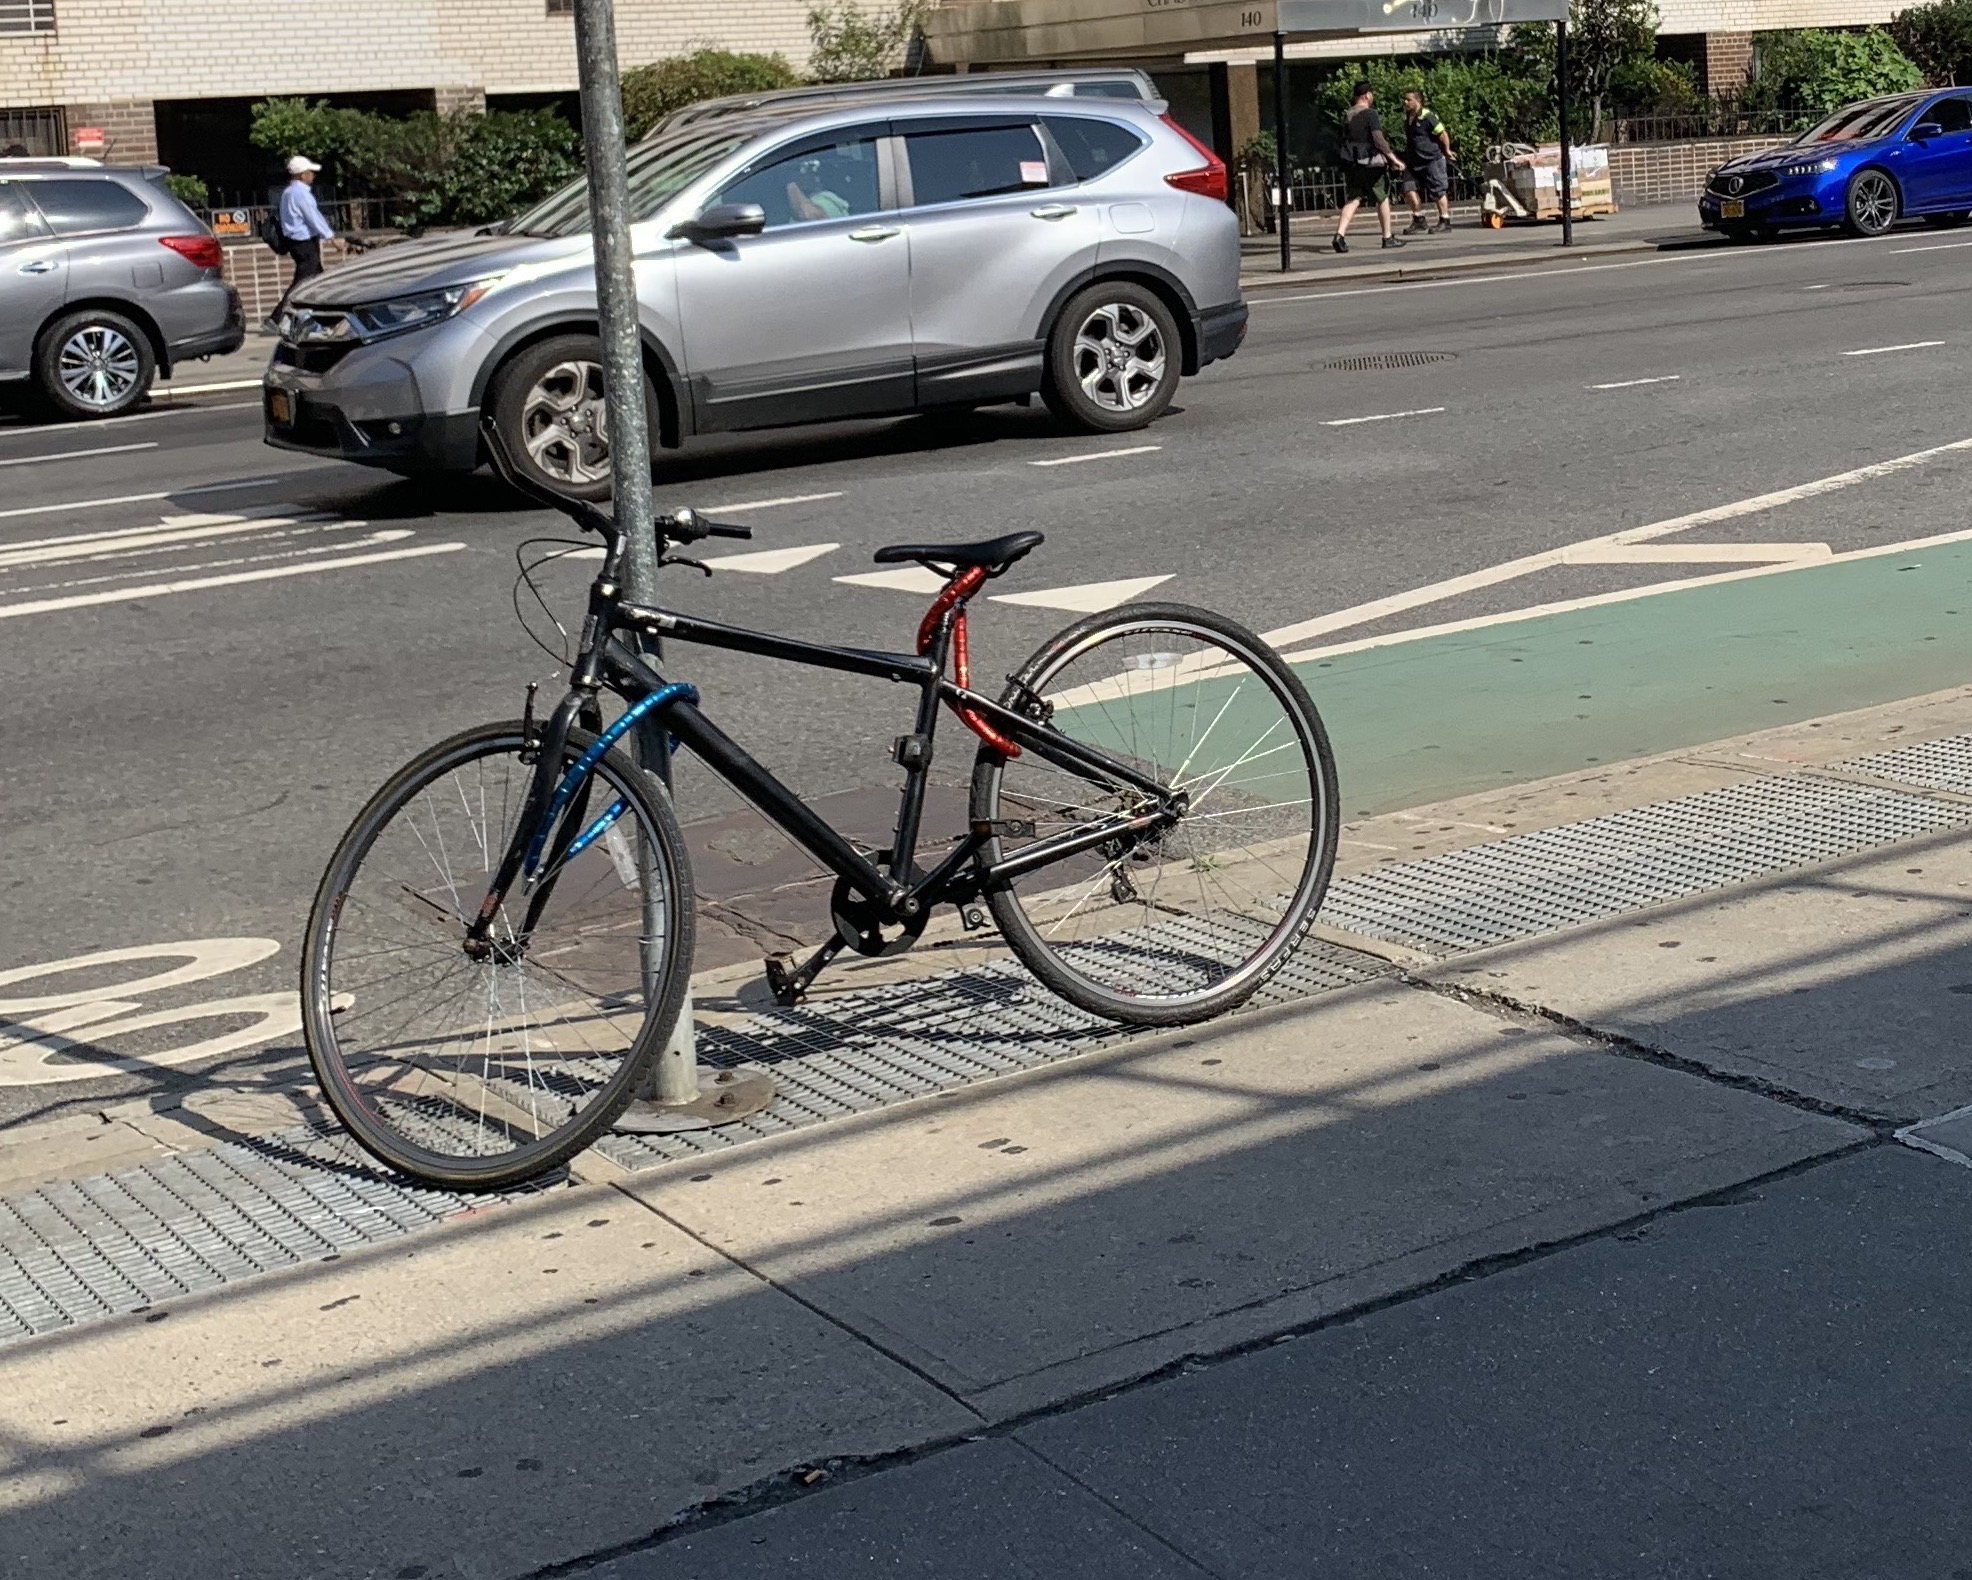

In [ ]:
Show(filename='bikes_data/images/bike/IMG_1494.JPG', width=640)

Notebooks aren't great at playing videos, so I posted `bikes_data/intersection_movie.mov` on [Vimeo](https://vimeo.com/354069170).

Now we need to load our image data in a format that's ready for the training code. We do that with fast.ai's data block.

In [ ]:
data_path = Path('./bikes_data/images') ## The path for our data

my_item_transforms = Resize(600)
my_batch_transforms = None  # note: We'll talk more about transforms later

def label_func(x): return x.parent.name
data = ImageDataLoaders.from_path_func(
    data_path,                       # here's where our files are
    get_image_files(data_path),      # specifically, here are their names
    label_func,                      # here's how to determine if an example has been labeled "circling" or "not_circling" (by using the folder it's in)
    item_tfms=my_item_transforms,    # to discuss later
    batch_tfms=my_batch_transforms,  # to discuss later
    bs=32
    )

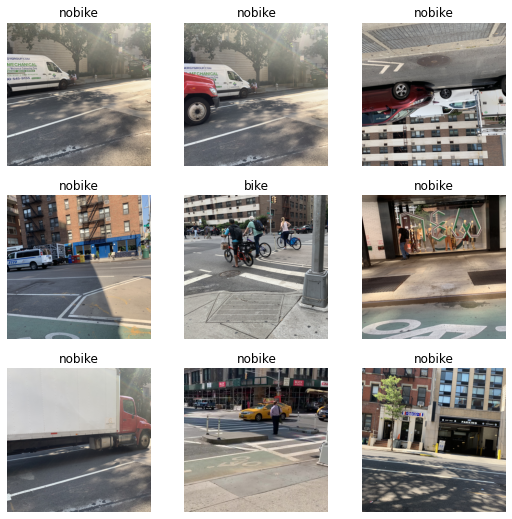

In [ ]:
data.show_batch(nrows=3)

In [ ]:
# Let's be sure to check our classes to make sure it's what we want.
print(data.vocab)

['bike', 'nobike']


## Training

Now we will start training our model. We will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Most people don't! For a deeper dive, check out the fast.ai courses.

But for now, you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories: 0 and 1

### Transfer learning with resnet34

Training a computer-vision mode from scratch to solve our problem would take thousands of images. Maybe more. Instead we take advantage of an existing model that was trained to detect objects -- from planes, to cars, to dogs, to birds -- by processing millions of images. This model is called "resnet34."

With fast.ai we can infuse this model with our images (and their labels). This takes advantage of all of resnet34's "knowledge" of image-detection and tacks on our particular problem. This technique is called "transfer learning."

First we load our `data` and `model.resnet34` together into a training model known as a "learner."

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


We will train for 6 "epochs" (6 cycles through all our data).

In [ ]:
learn.fine_tune(6)

#### How are we doing?

So far, we have a pretty good error rate. It's actually possible to do even better, but we'll stick with this for now.

We can take a look to see where the model was most confused, and whether what the model predicted was reasonable or not.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

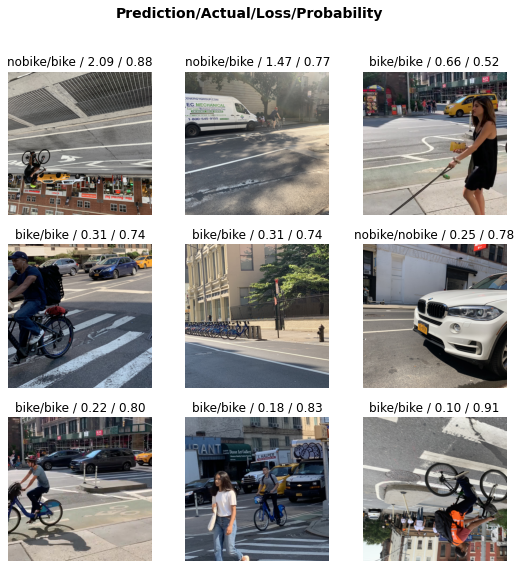

In [ ]:
interp.plot_top_losses(9)

We can also see the situations in which it was most confused:

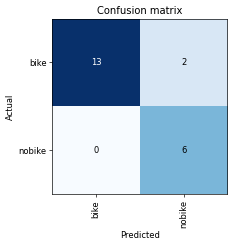

In [ ]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

Let's save what we have in case we mess it up later!

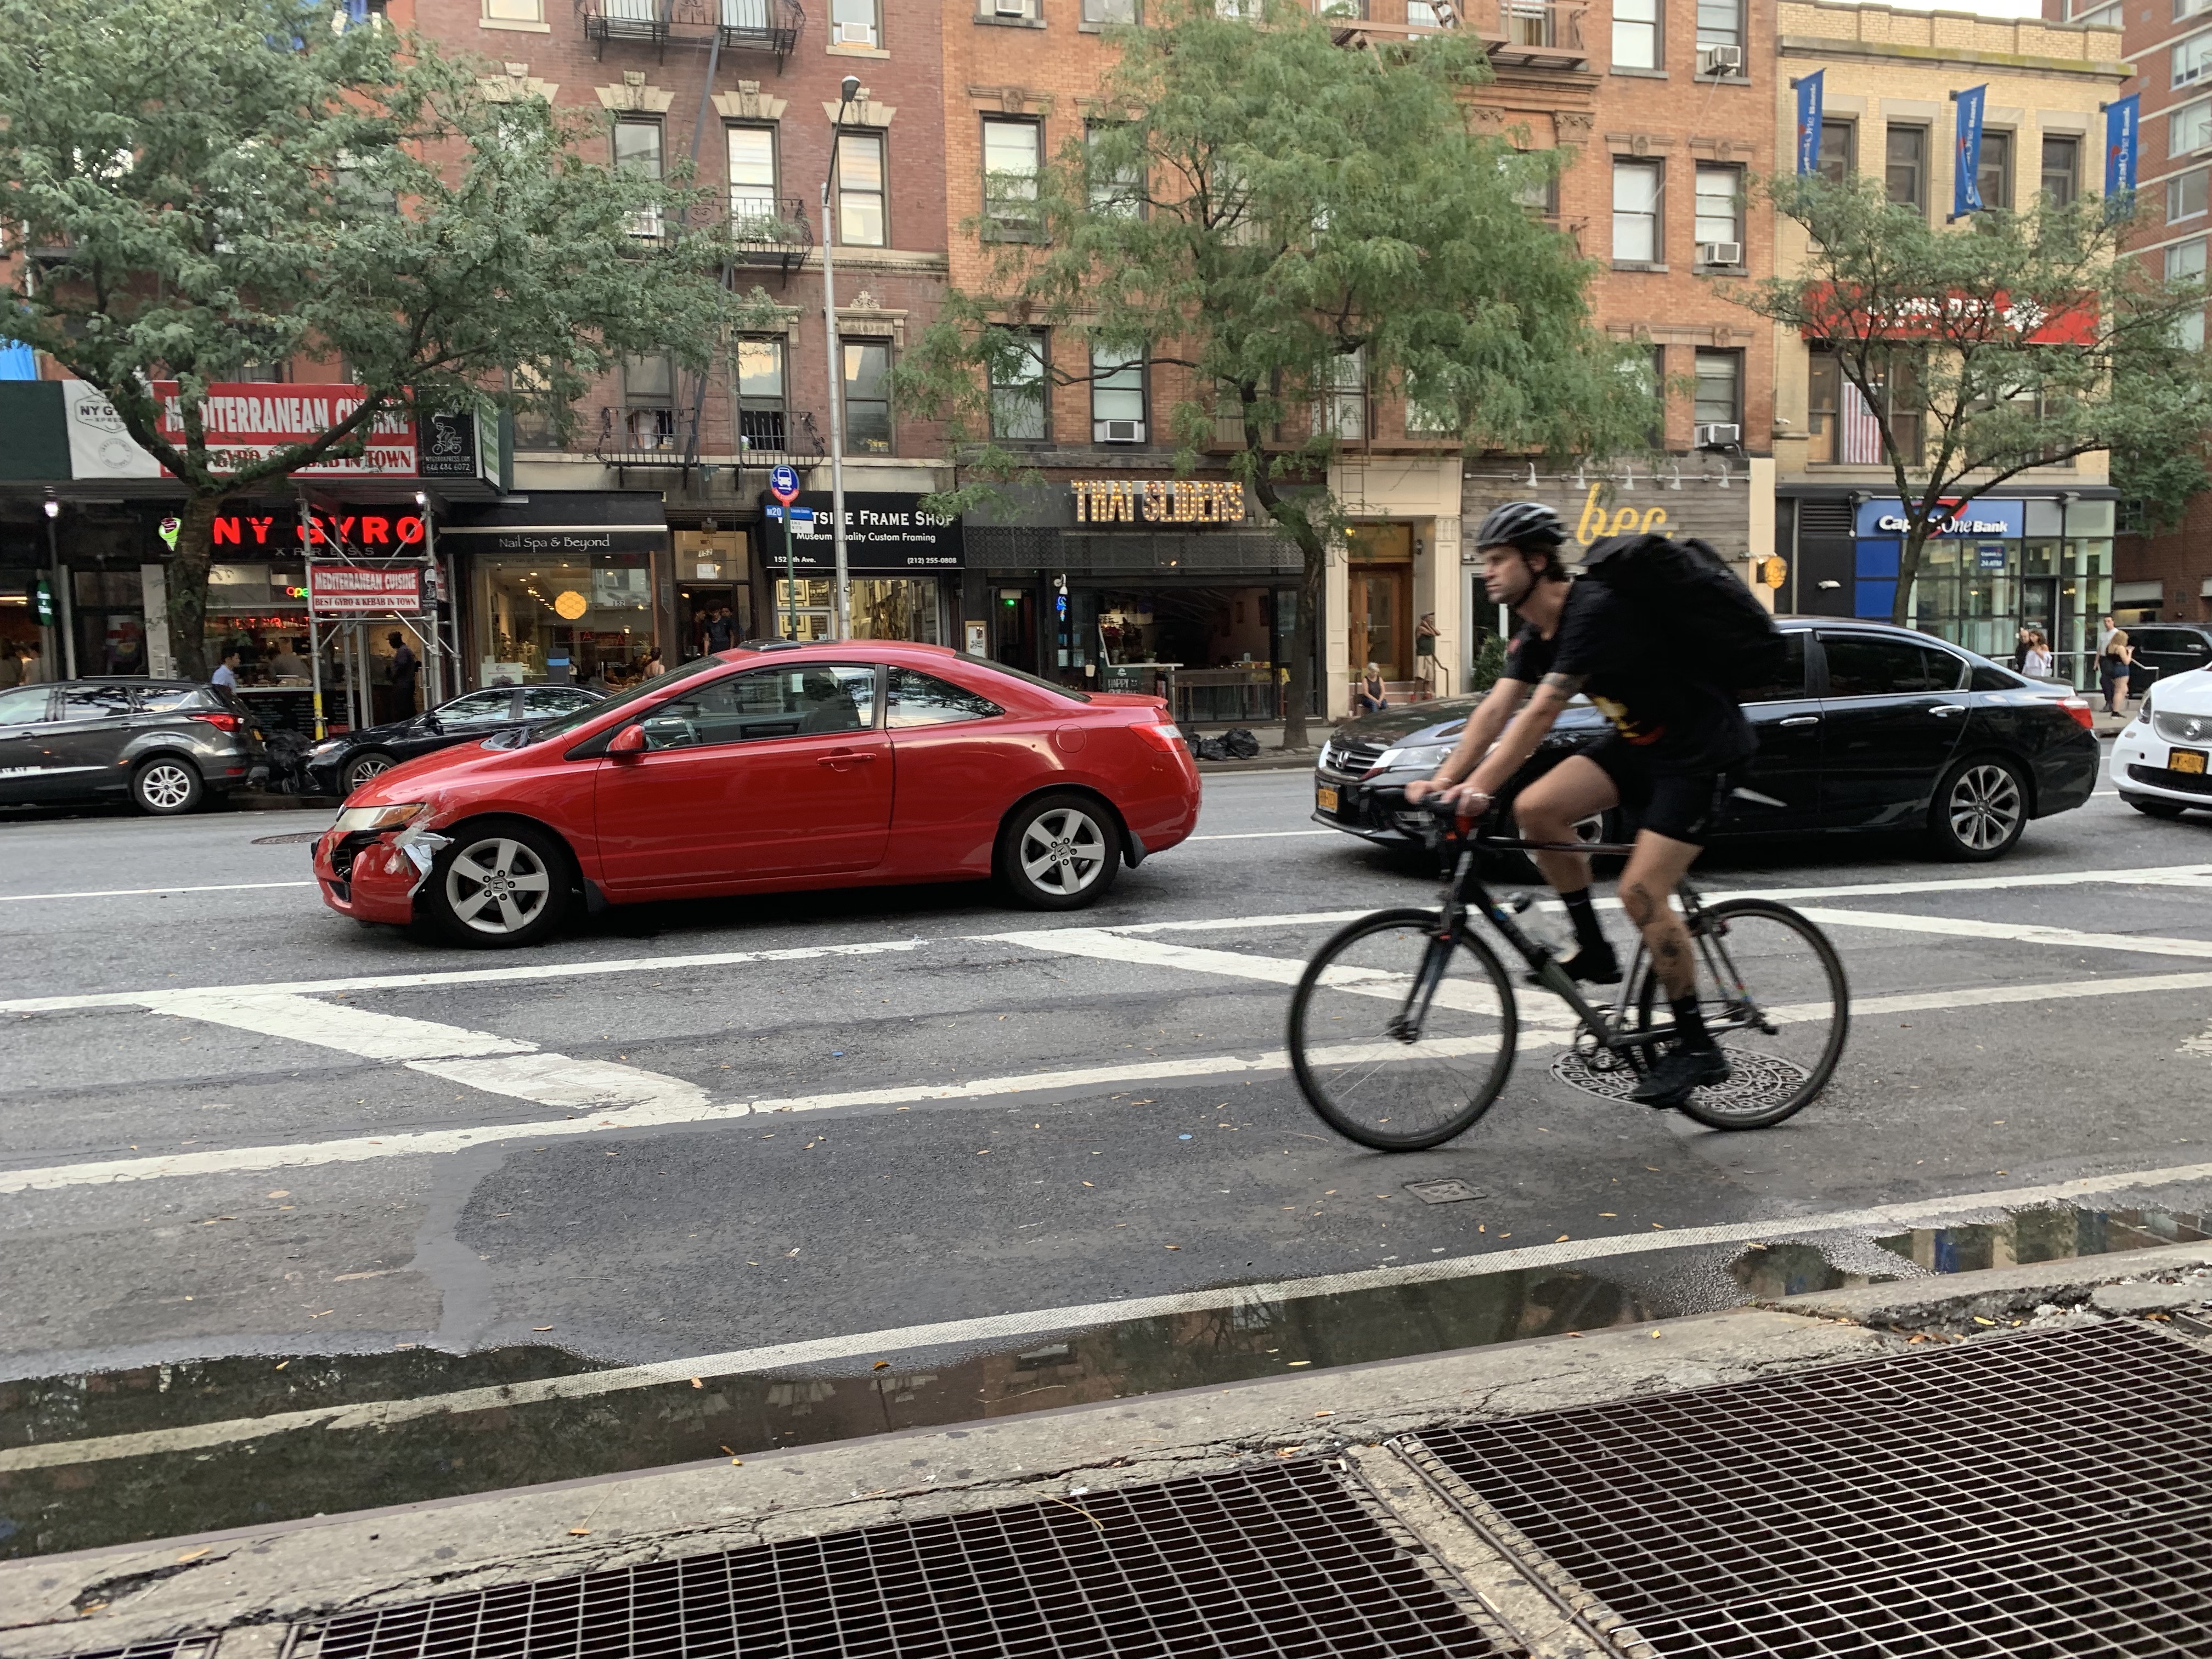

In [ ]:
Show(filename='bikes_data/never_seen_image.jpg', width=640)

In [ ]:
img = PILImage.create('bikes_data/never_seen_image.jpg')

In [ ]:
# actually predicting
pred_class, pred_idx, outputs = learn.predict(img)

In [ ]:
# what is "pred_class"? The model's guess of the right answer!
pred_class

'bike'

In [ ]:
# what are "outputs"? That's the model's guess of the probability per class
outputs

tensor([0.9587, 0.0413])

In [ ]:
outputs[0]

tensor(0.9587)

We're also going to _export_ the entire package as a "pickle" file called `export.pkl`

**Warning for Google Colab users!** Later, when you've done more fine tuning and want to save what you've done, you need to give permission for this notebook to write files to your Google Drive. In that case, you'll want to run the next cell and follow the permission-granting steps. For now, you can skip this.

In [ ]:
## THIS CELL WILL ALLOW GOOGLE COLAB USERS SAVE MODELS TO YOUR GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


root_dir = "/content/gdrive/My Drive/"


In [ ]:
# # if you don't want to save to Google drive, remove the # on the line below, and run thatinstead
# root_dir = './'

In [ ]:
save_path = Path(root_dir + 'ai-bikes/')
save_path.mkdir(parents=True, exist_ok=True)
learn.path = save_path
learn.export()

## Search our video

Now we'll apply our model to our video! First we need to turn the video into a bunch of images using `ffmpeg`, which we loaded at the beginning of this notebook.

In [ ]:
!ffmpeg -i bikes_data/intersection_movie.mov -vf fps=1 -hide_banner -loglevel panic -vsync 0 myframe%04d.jpg

In [ ]:
%ls

ai-bikes/        myframe0010.jpg  myframe0022.jpg  myframe0034.jpg
bikes_data/      myframe0011.jpg  myframe0023.jpg  myframe0035.jpg
bikes_data.zip   myframe0012.jpg  myframe0024.jpg  myframe0036.jpg
myframe0001.jpg  myframe0013.jpg  myframe0025.jpg  myframe0037.jpg
myframe0002.jpg  myframe0014.jpg  myframe0026.jpg  myframe0038.jpg
myframe0003.jpg  myframe0015.jpg  myframe0027.jpg  myframe0039.jpg
myframe0004.jpg  myframe0016.jpg  myframe0028.jpg  myframe0040.jpg
myframe0005.jpg  myframe0017.jpg  myframe0029.jpg  myframe0041.jpg
myframe0006.jpg  myframe0018.jpg  myframe0030.jpg  myframe0042.jpg
myframe0007.jpg  myframe0019.jpg  myframe0031.jpg  sample_data/
myframe0008.jpg  myframe0020.jpg  myframe0032.jpg
myframe0009.jpg  myframe0021.jpg  myframe0033.jpg


In [ ]:
glob.glob('myframe*.*')

['myframe0033.jpg',
 'myframe0035.jpg',
 'myframe0037.jpg',
 'myframe0003.jpg',
 'myframe0019.jpg',
 'myframe0014.jpg',
 'myframe0042.jpg',
 'myframe0010.jpg',
 'myframe0012.jpg',
 'myframe0041.jpg',
 'myframe0038.jpg',
 'myframe0009.jpg',
 'myframe0008.jpg',
 'myframe0001.jpg',
 'myframe0021.jpg',
 'myframe0017.jpg',
 'myframe0026.jpg',
 'myframe0023.jpg',
 'myframe0020.jpg',
 'myframe0002.jpg',
 'myframe0018.jpg',
 'myframe0025.jpg',
 'myframe0032.jpg',
 'myframe0031.jpg',
 'myframe0028.jpg',
 'myframe0034.jpg',
 'myframe0036.jpg',
 'myframe0024.jpg',
 'myframe0027.jpg',
 'myframe0011.jpg',
 'myframe0007.jpg',
 'myframe0029.jpg',
 'myframe0039.jpg',
 'myframe0005.jpg',
 'myframe0006.jpg',
 'myframe0004.jpg',
 'myframe0015.jpg',
 'myframe0040.jpg',
 'myframe0016.jpg',
 'myframe0013.jpg',
 'myframe0030.jpg',
 'myframe0022.jpg']

If we had saved the exported model as a "pickle" or `.pkl` file, the next line would load it in from disk.

In [ ]:
# learn = load_learner(path)  # this gets the exported pickle file, which is stored in the image data path

In [ ]:
file_list = sorted(glob.glob('myframe*.*'))

for file in file_list:
    image = PILImage.create(file)
    pred_class,pred_idx,outputs = learn.predict(image)
        
    if str(pred_class) == "bike" and outputs[0] > 0.85:
        print(f'Bike detected in {file} with confidence {outputs[0]}')
    

Bike detected in myframe0005.jpg with confidence 0.8585077524185181


Bike detected in myframe0022.jpg with confidence 0.9999707937240601


Bike detected in myframe0023.jpg with confidence 0.9981006979942322


Bike detected in myframe0024.jpg with confidence 0.9999436140060425


Bike detected in myframe0031.jpg with confidence 0.9504795074462891


Bike detected in myframe0036.jpg with confidence 0.9959920048713684


Bike detected in myframe0037.jpg with confidence 0.9957679510116577


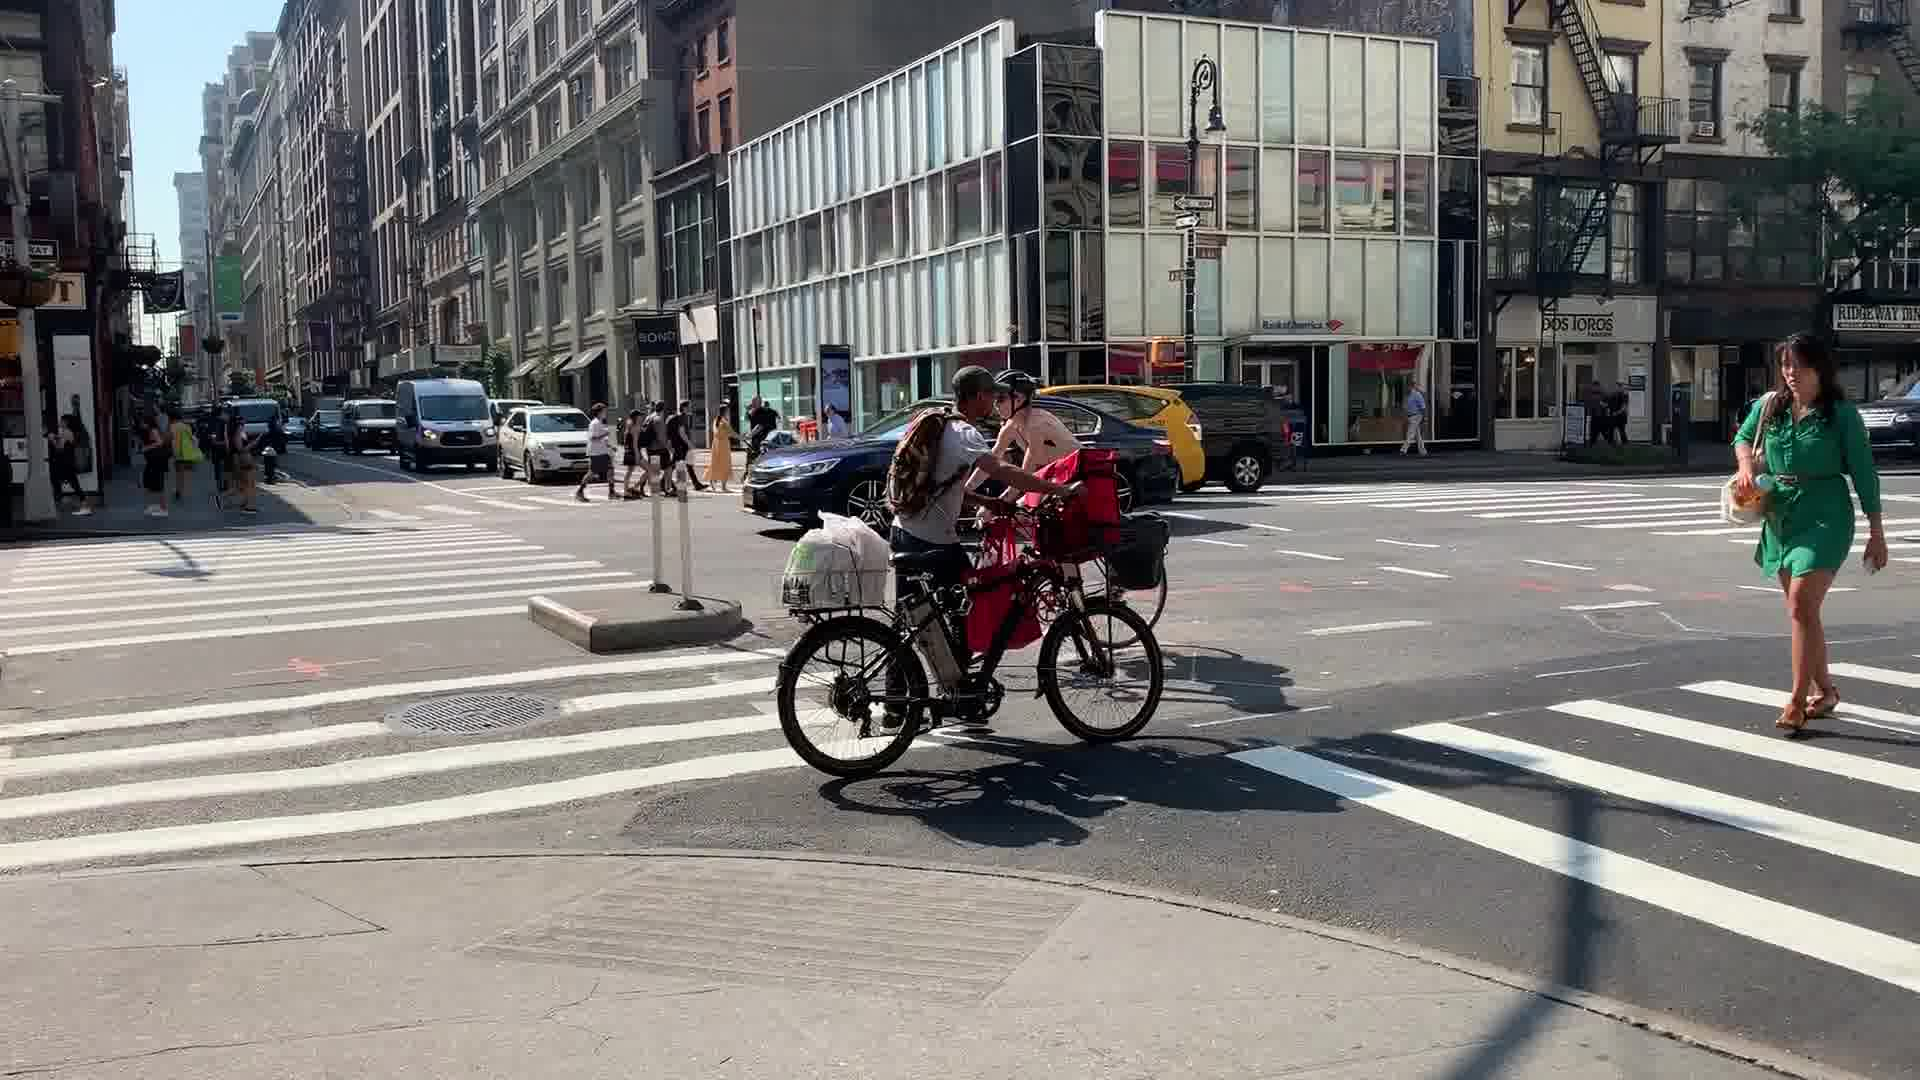

In [ ]:
Show(filename='myframe0023.jpg', width=640)

## Discussion questions

1.   We had 108 training examples. How well do you think our model would do with 300 training examples?
2.   We had 54 `bike` examples and `no_bike` examples. What do you think would happen if we had 216 `no_bike` and still 54 `bike`? If there's a problem, how might we fix it?
3. Got any ideas of stories where finding "stuff" in a big corpus of videos would be helpful? How have you solved problems like that in the past?

